In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chisquare, chi2_contingency
import scipy.stats  as stats
import nltk
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from IPython.display import display, Markdown, Latex, Image
import urllib.request
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

### fonctions

In [9]:
def proport(ser): # prend une serie numérique de pandas et retourne la proportion de chaque valeur dans la somme
    
    somme = ser.sum()
    ser2=ser.transform (lambda x : x*100/somme)
    
    return (ser2)

In [11]:
def nettoy(x):  # pour le nettoyage de la colonne categorie principale
    if pd.notnull(x):
        if len(x)>3:
            if x[2]==':':
                x=x.replace('-',' ')
                return(x[3:])
            else :
                return(x)
        else :
            return(x)
    else :
        return(x)
            

In [12]:
def Classif(cat,gro):
    if np.logical_and(pd.notnull(cat),pd.notnull(gro)):
        sta='Les deux'
    elif (pd.isnull(cat) & pd.isnull(gro)):
        sta='Aucun'
    elif (pd.isnull(cat) & pd.notnull(gro)):
        sta='PNNS uniquement'
    elif (pd.notnull(cat) & pd.isnull(gro)):
        sta='Catégorie uniquement'
    return sta

In [13]:
Etiquette = ['Energie','Graisses saturees','Graisses','Glucides','Sucres','Proteines', 'Sel']
Etiquette2 = ['Graisses saturees','Graisses','Glucides','Sucres','Proteines', 'Sel']
carac=['Proteines','Sucres','Graisses saturees', 'Fruits/Legumes/Noix','Energie','Fibres','Glucides']
carac2=['Proteines','Sucres','Graisses saturees', 'Fruits/Legumes/Noix','Fibres', 'Glucides', 'Sel']

ValeursInt=set()
for i in carac :
    ValeursInt.add(i)
for i in Etiquette :
    ValeursInt.add(i)
ValeursInt.add('Nutri-Score')

### loading du fichier

In [14]:
baseT = pd.read_csv('BaseRetraiteeV1.csv')

### Etude du code barre

In [15]:
baseT['code'].describe()

count    3.463640e+05
mean     2.486981e+12
std      1.163640e+12
min      1.700000e+01
25%      2.184994e+12
50%      3.107400e+12
75%      3.292320e+12
max      8.480001e+12
Name: code, dtype: float64

In [16]:
baseT['code'].isnull().sum()

0

#### Aucune valeur nulle au niveau du code barre

# Analyse des catégories de produits

In [17]:
baseCat=baseT[['Groupe PNNS 2','Sous-groupe PNNS 2','Categories']]
baseCat.describe()

,Groupe PNNS 2,Sous-groupe PNNS 2,Categories
count,168390,167004,189555
unique,9,38,30939
top,Fish Meat Eggs,Processed meat,Snacks
freq,37023,16539,3277


### Taux de remplissage du Nutri-Score dans la base

([<matplotlib.patches.Wedge at 0x7f8e6c655250>,
 [Text(0.10351914875166042, 1.0951181606757014, 'Produits sans Nutri-Score :47% '),
  Text(-0.10351925128402203, -1.0951181509835346, 'Produits avec Nutri-Score : 53%')])

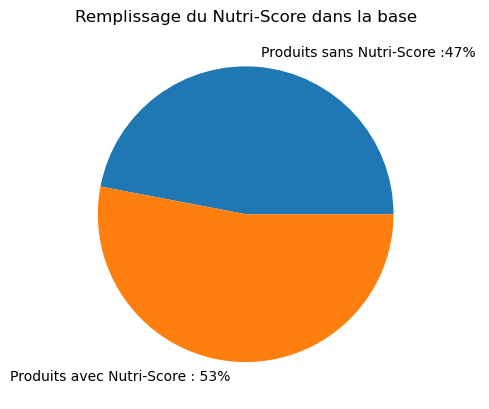

In [18]:
plt.style.use('default')
NutriNull =baseT['Note de Nutri-Score'].isnull().sum()
NutriNotN = baseT['Note de Nutri-Score'].notnull().sum()
PNutriNull = round(NutriNull/(len(baseT))*100,0)
PNutriNotN = round(NutriNotN/(len(baseT))*100,0)
plt.title('Remplissage du Nutri-Score dans la base')
plt.pie([PNutriNull, PNutriNotN], \
labels=['Produits sans Nutri-Score :{}% '.format(int(PNutriNull)),'Produits avec Nutri-Score : {}%'.format(int(PNutriNotN))])

In [19]:
baseF=baseT.copy() # une sauvegarde

### Distribution des valeurs nutritionnelles en histogramme et boxplot

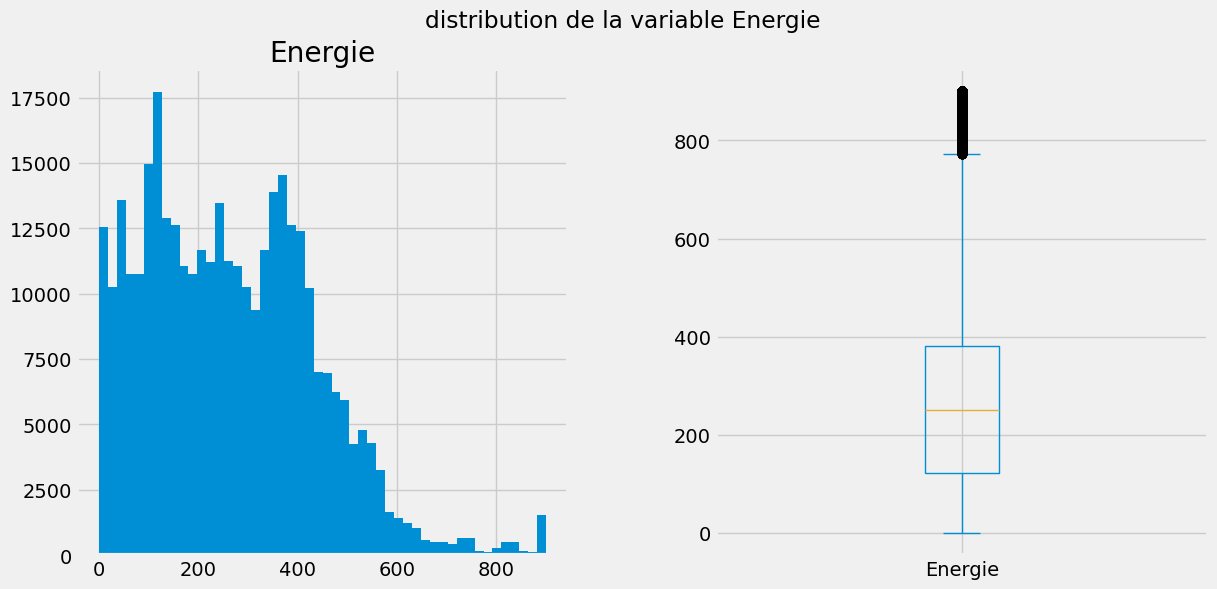

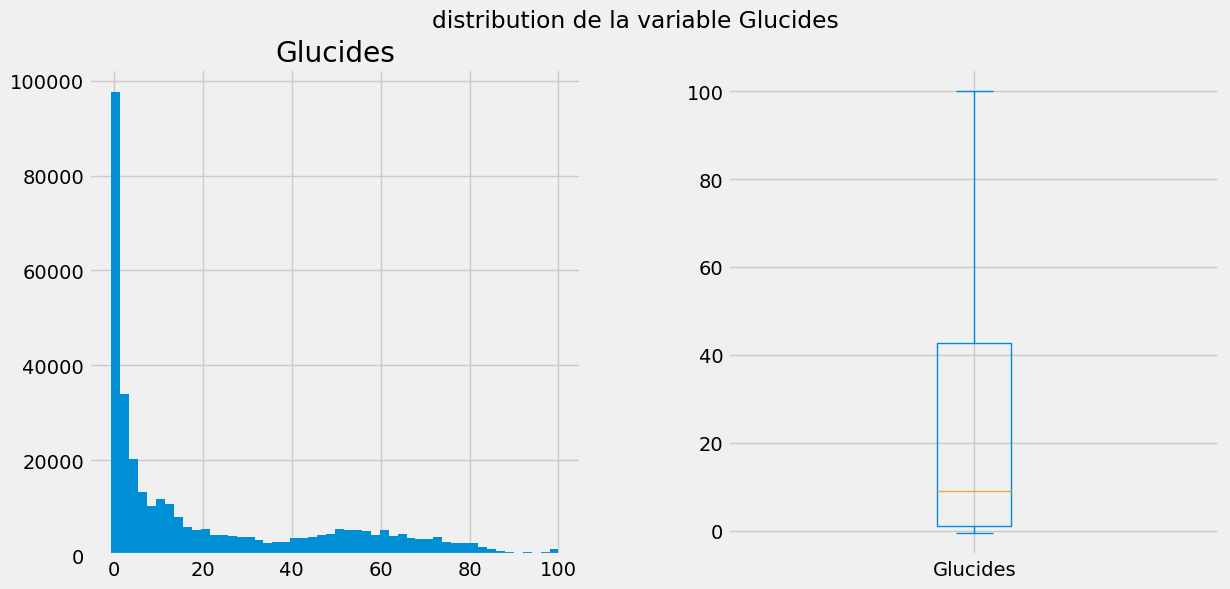

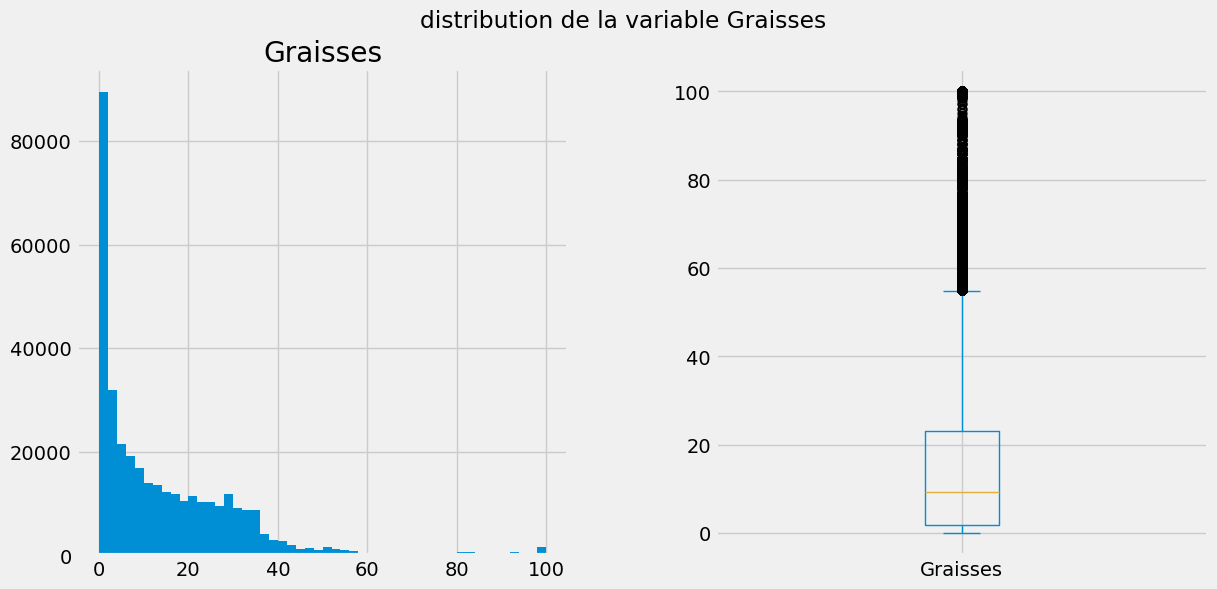

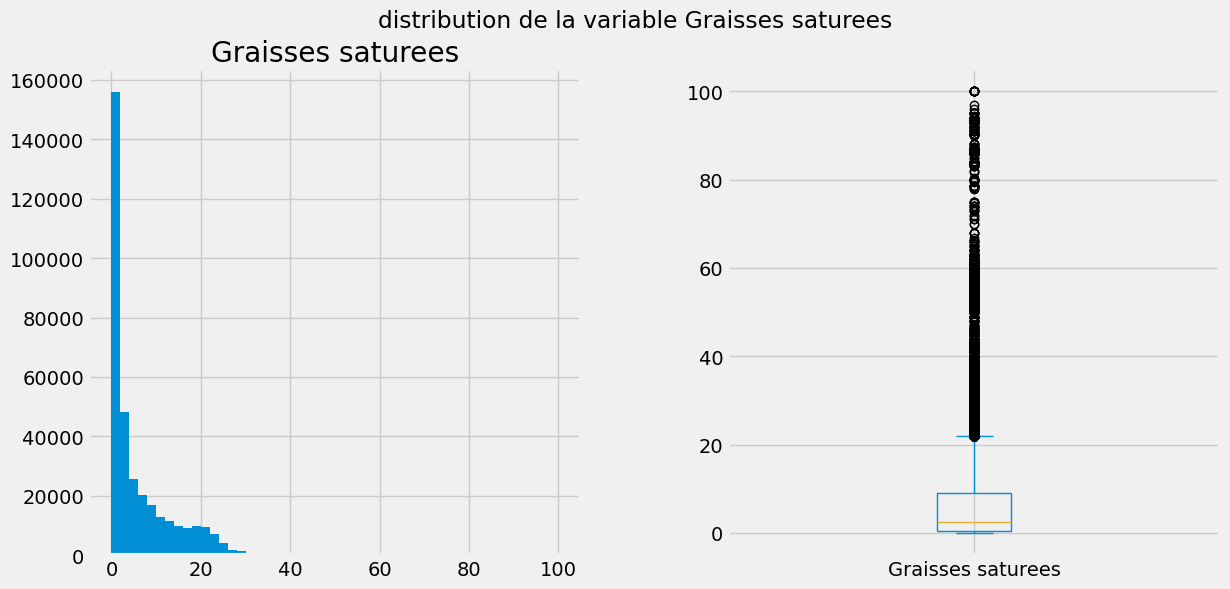

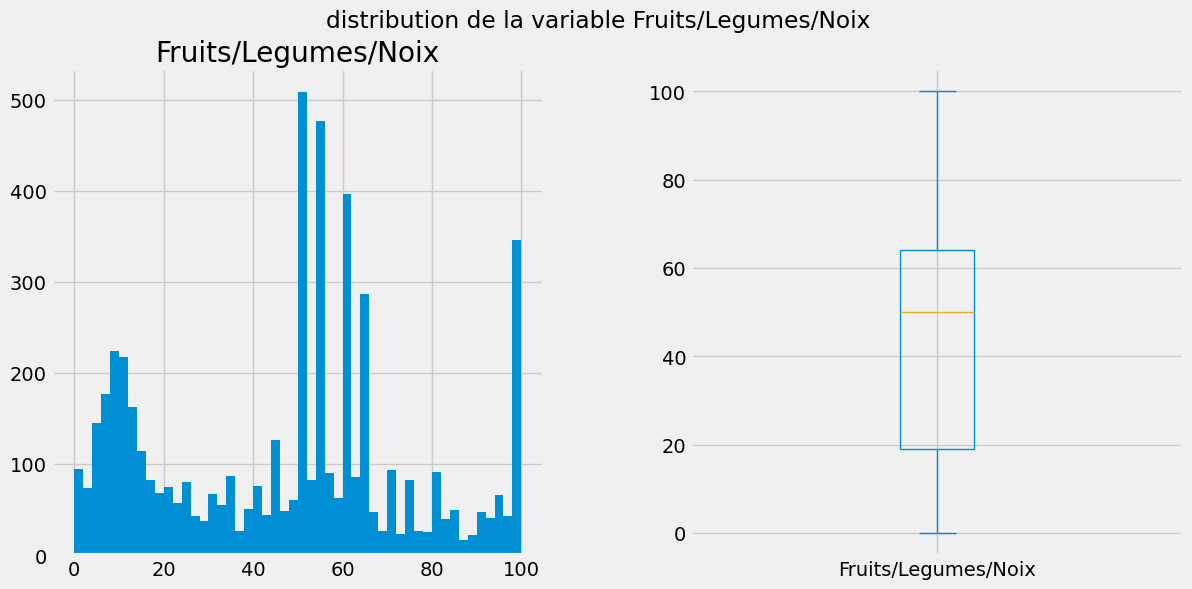

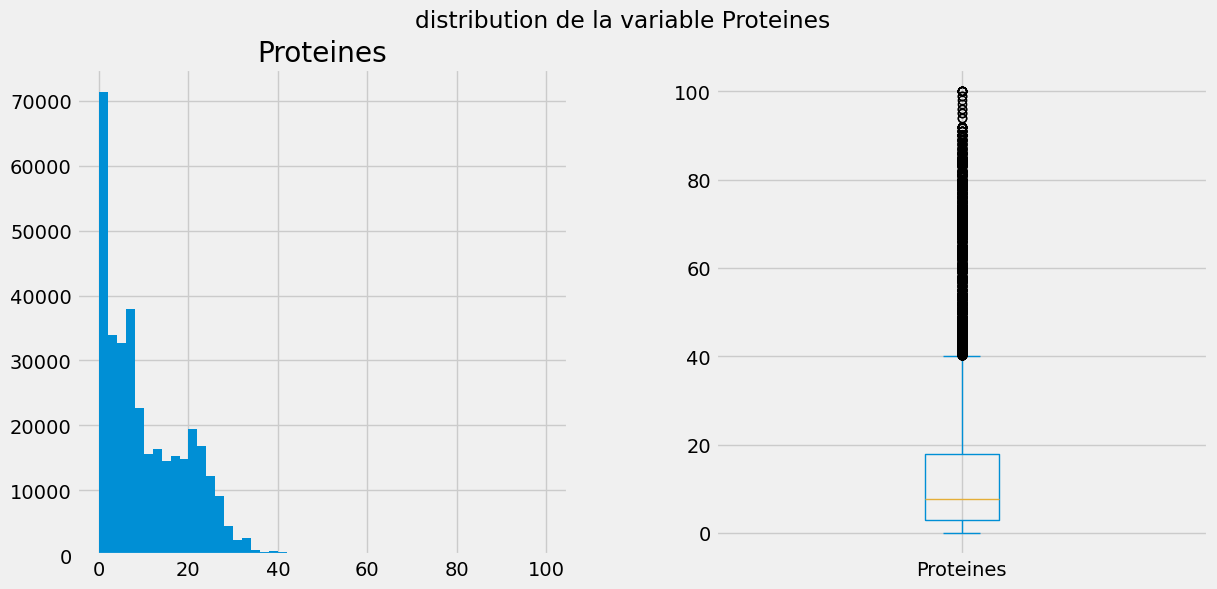

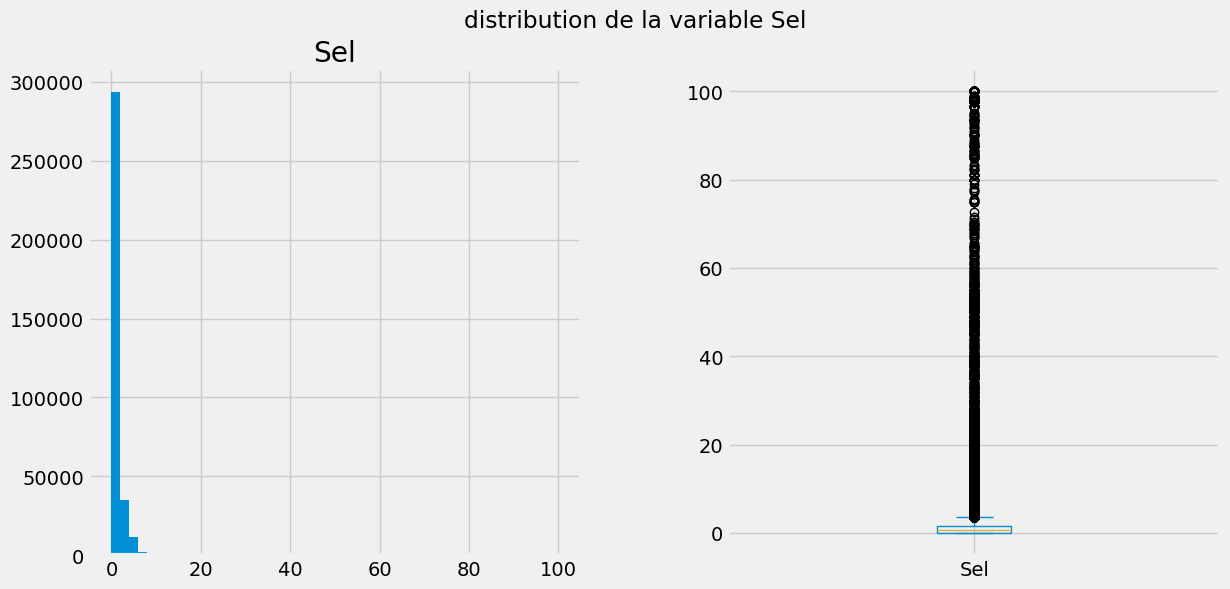

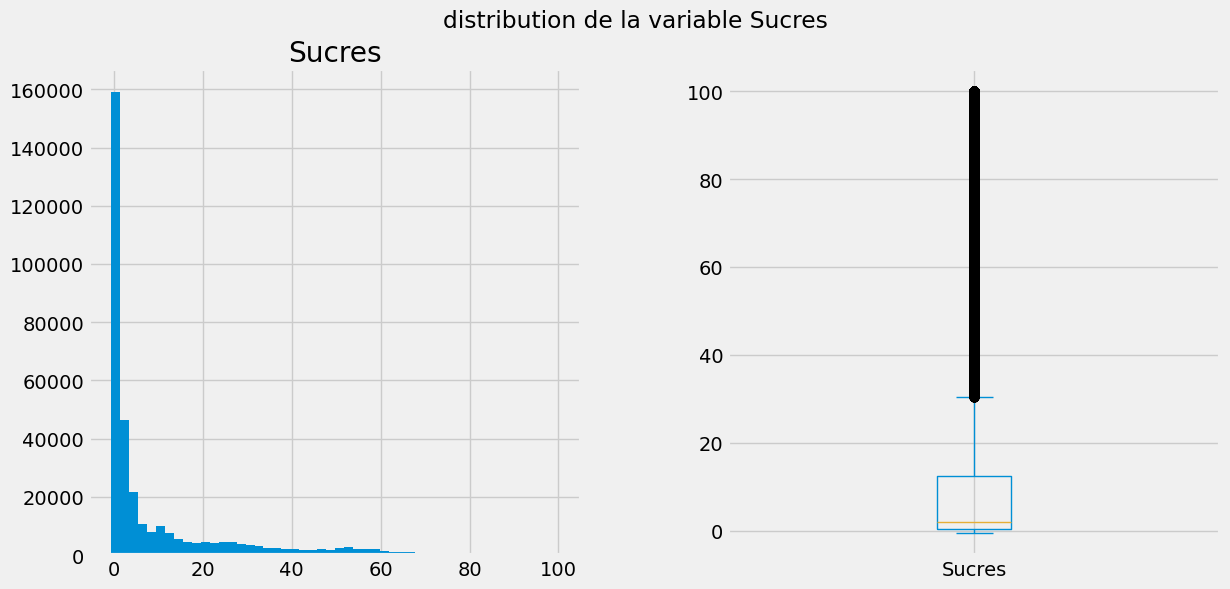

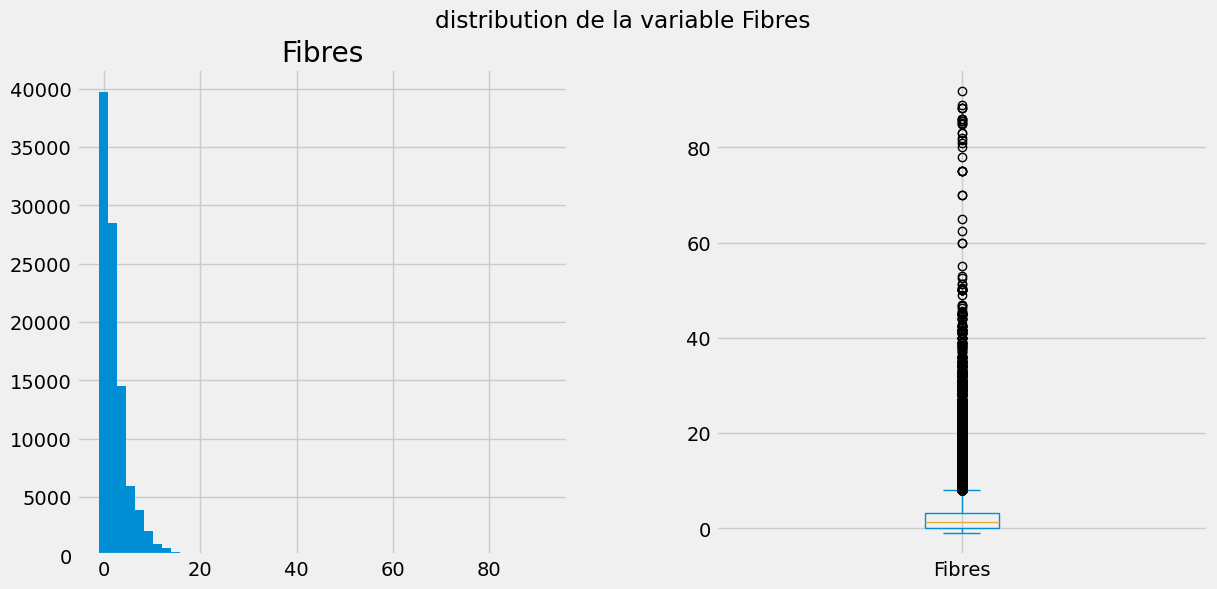

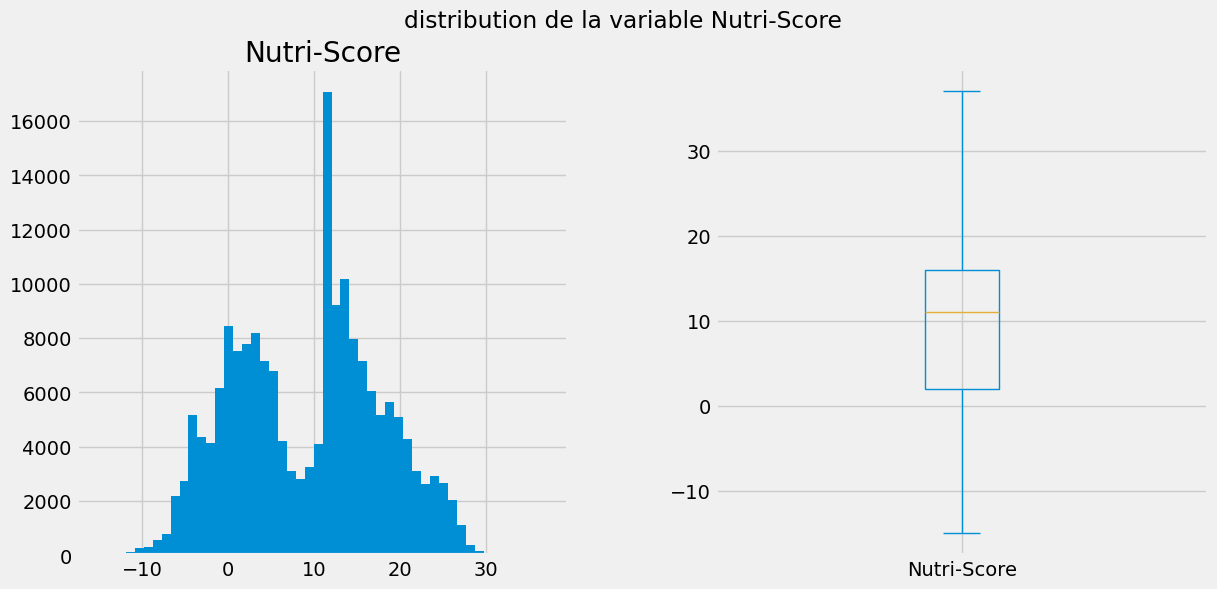

In [20]:
plt.style.use('fivethirtyeight')
for i in ValeursInt :  # Distribution des colonnes numériques
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[13,6])
    fig.suptitle('distribution de la variable '+ i)
    baseT[[i]].hist(bins=50, ax=axes[0])
    baseT[[i]].plot(kind='box',ax=axes[1])

Text(0.5, 0, 'Catégorie de Nutri-Score')

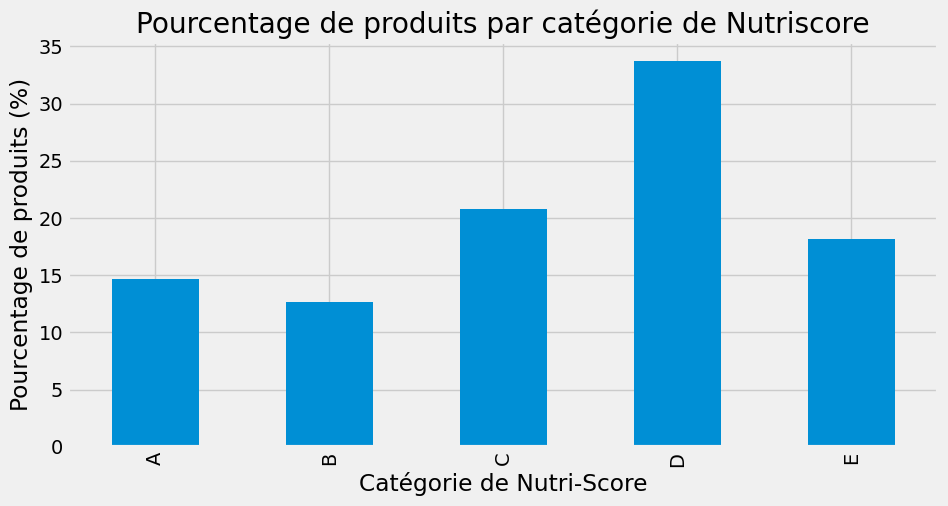

In [21]:
((baseT['Note de Nutri-Score'].value_counts(normalize=True)*100).sort_index()).plot(kind='bar', figsize=[10,5],\
title='Pourcentage de produits par catégorie de Nutriscore')
plt.ylabel('Pourcentage de produits (%)')
plt.xlabel('Catégorie de Nutri-Score')

### Distribution des valeurs numériques par catégorie de Nutri-Score

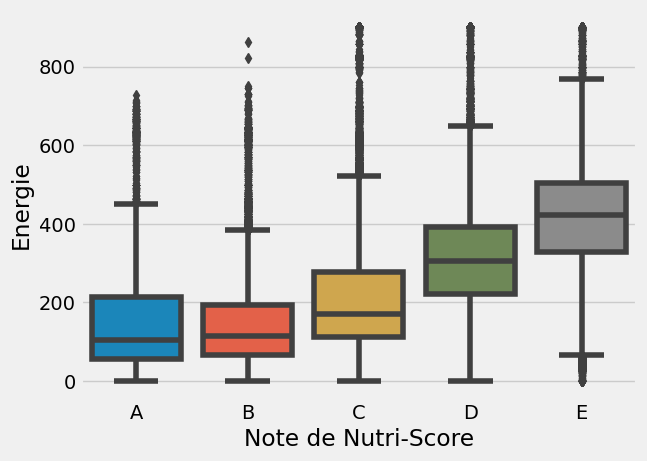

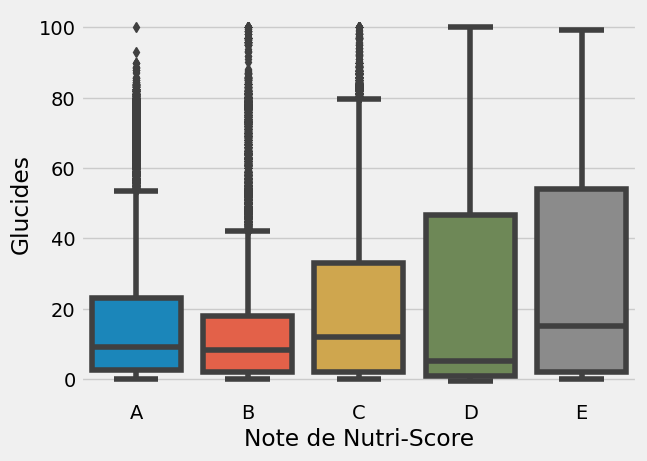

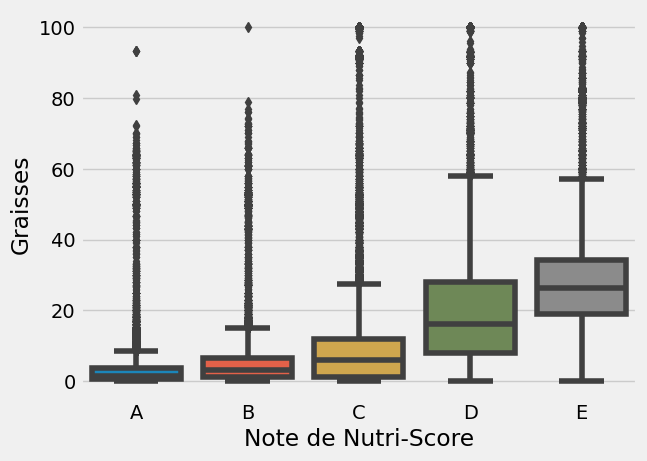

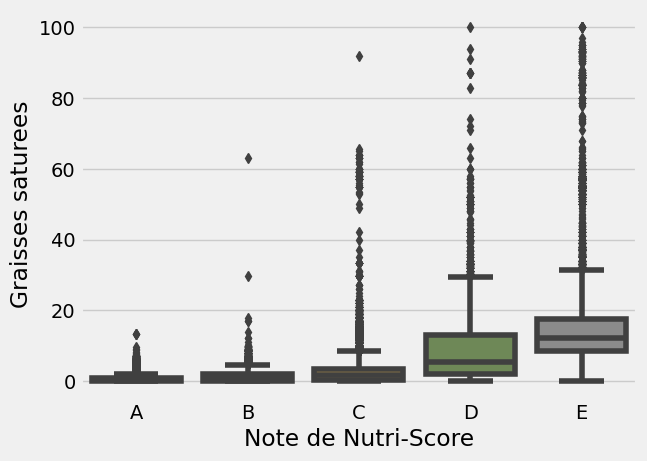

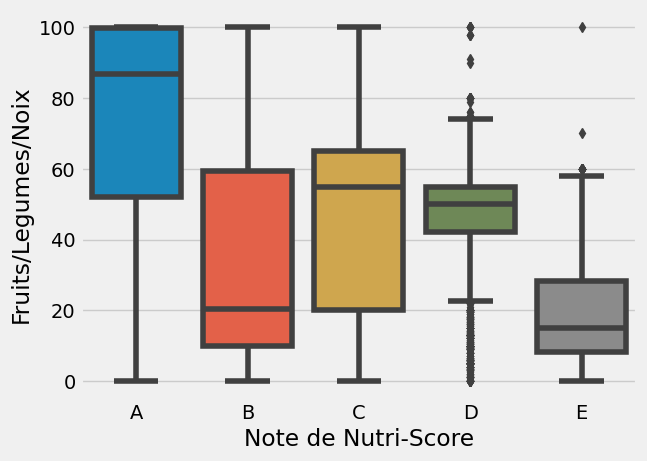

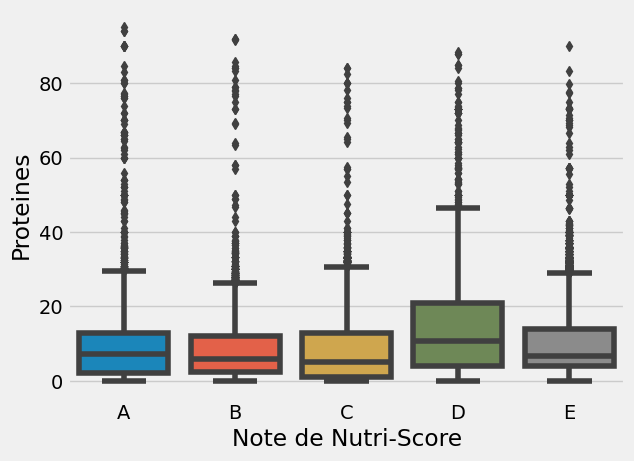

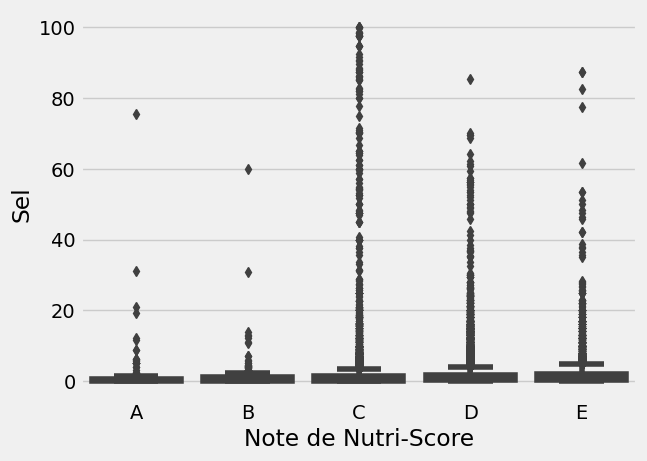

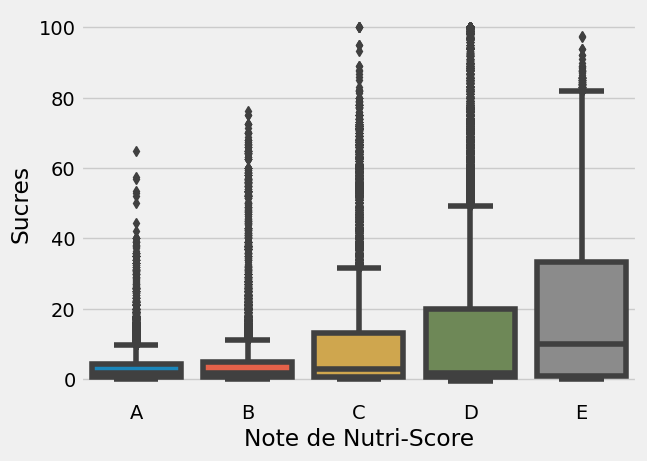

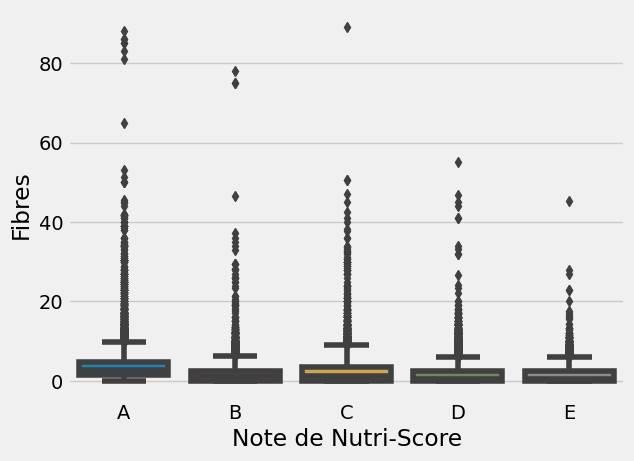

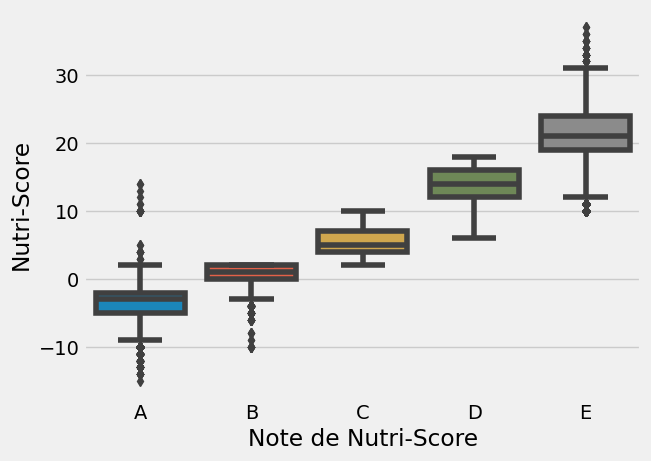

In [22]:
for i in ValeursInt :
    plt.figure()
    sns.boxplot(x='Note de Nutri-Score',y=i, data=baseT, order=('A','B','C','D','E'))
    

### relation entre le nutriscore et le nova group

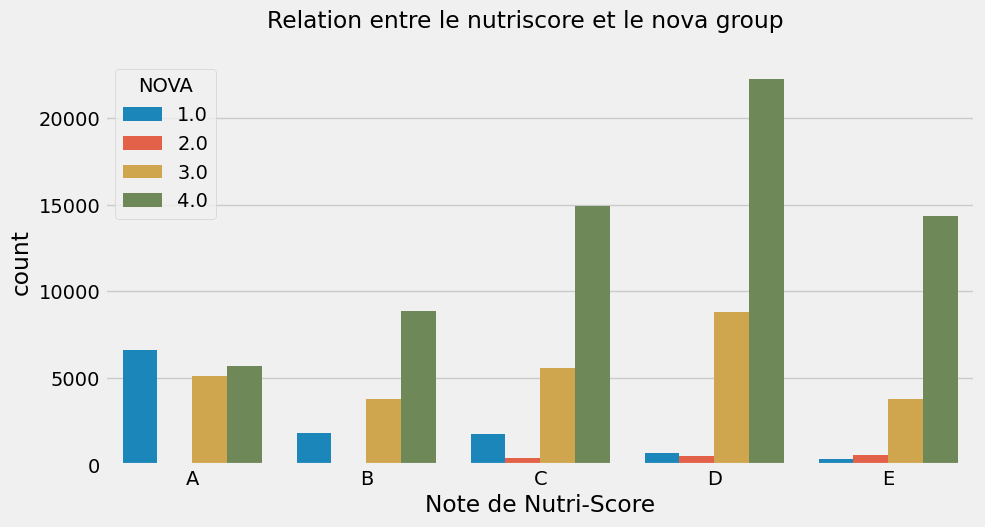

In [23]:
z=baseT.loc[:,['Note de Nutri-Score','NOVA']]
z['Note de Nutri-Score']=z['Note de Nutri-Score'].astype('category')
plt.figure(figsize=[10,5])
plt.suptitle('Relation entre le nutriscore et le nova group')
sns.countplot(x='Note de Nutri-Score',hue='NOVA', data=z, order=['A','B','C','D','E'])
z['nb']=1       


Text(0, 0.5, 'Pourcentage de produit')

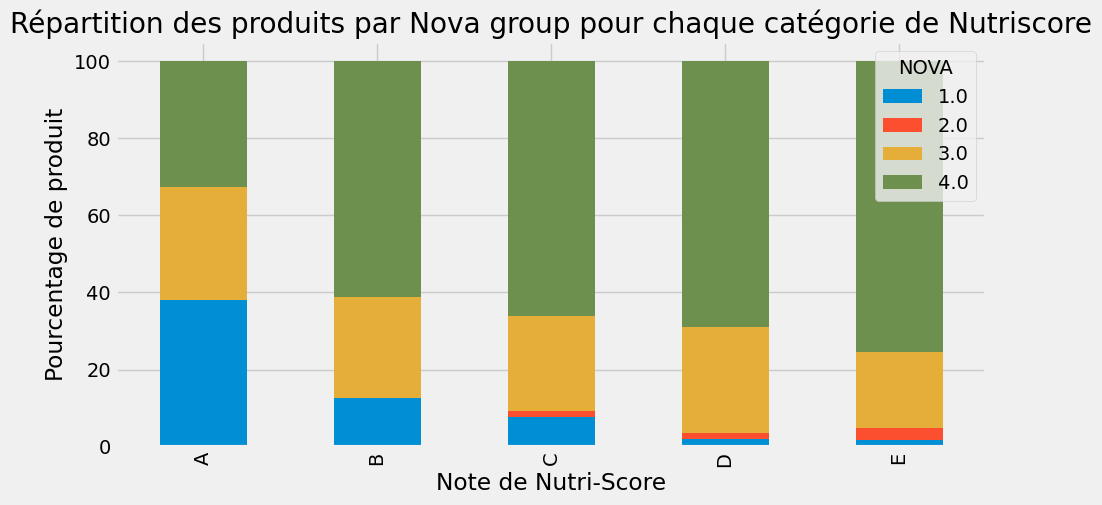

In [24]:
zz=z.pivot_table(index=['NOVA'], columns=['Note de Nutri-Score'], values=['nb'], aggfunc=sum)
zz=zz.droplevel([0], axis=1)
zz1=zz.transform(proport).T
zz1.plot.bar(stacked=True, figsize=[10,5], title='Répartition des produits par Nova group pour chaque catégorie de Nutriscore')
plt.ylabel('Pourcentage de produit')

## Test d'independance du Chi-2

tableau de contingence :

In [93]:
crossta=pd.crosstab(baseT['NOVA'],baseT['Note de Nutri-Score'])
crossta

Note de Nutri-Score,A,B,C,D,E
NOVA,,,,,
1.0,6598,1837,1753,657,338
2.0,9,5,366,487,574
3.0,5113,3770,5553,8825,3781
4.0,5671,8875,14905,22275,14378


Distribution théorique en cas d'indépendance du Nova score et de la note de nutri-score:

In [94]:
test,pval,dof, expected=chi2_contingency(crossta)
crossta_exp=pd.DataFrame(expected,columns=crossta.columns,index=crossta.index)
crossta_exp

Note de Nutri-Score,A,B,C,D,E
NOVA,,,,,
1.0,1838.740219,1531.702004,2387.052955,3409.139189,2016.365633
2.0,236.933261,197.369453,307.586811,439.289061,259.821414
3.0,4446.321471,3703.861719,5772.215505,8243.757663,4875.843642
4.0,10869.005049,9054.066824,14110.144729,20151.814087,11918.969311


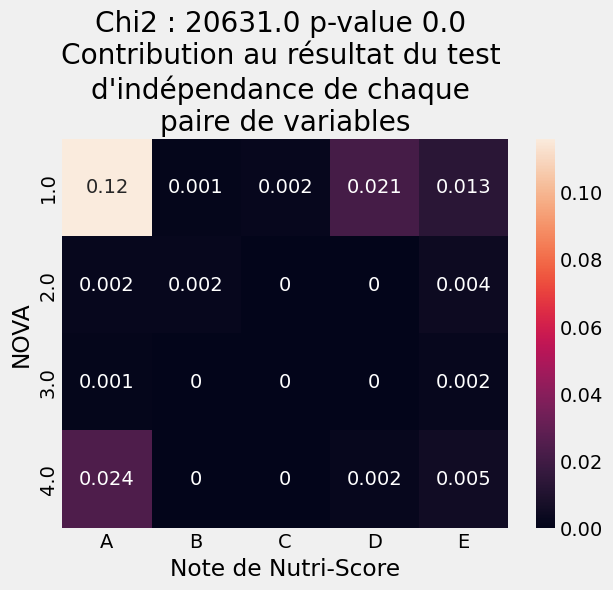

In [121]:
contrib=np.round(((crossta_exp-crossta)**2/crossta_exp)/crossta.sum().sum(),3)
sns.heatmap(contrib,annot=True)
plt.title('Chi2 : {} p-value {} \nContribution au résultat du test \nd\'indépendance de \
chaque \npaire de variables'.format(round(test,0),pval));

### relation entre la note de nutriscore et les autres variables numériques

Energie  coef :  0.59 
 p-value :  0.0 
 sur  183067  enregistrements


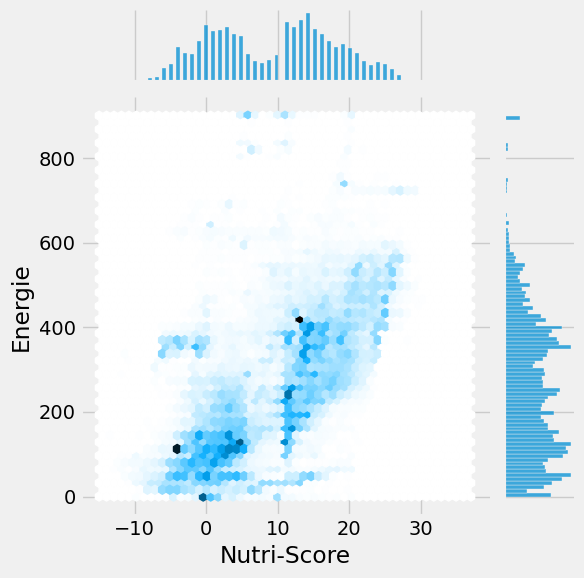

Glucides  coef :  0.17 
 p-value :  0.0 
 sur  183067  enregistrements


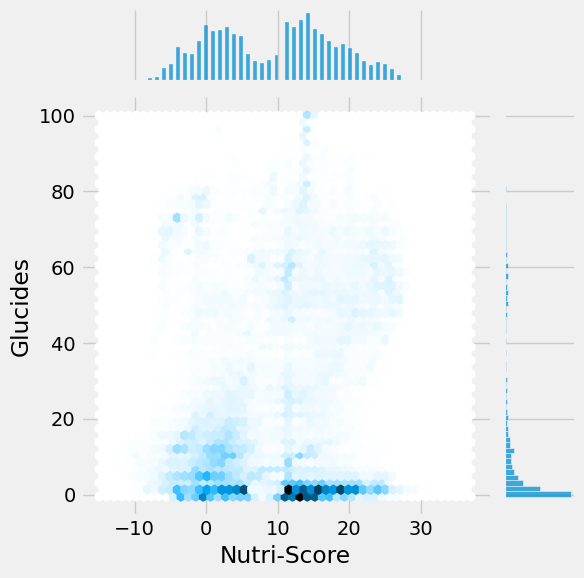

Graisses  coef :  0.53 
 p-value :  0.0 
 sur  183067  enregistrements


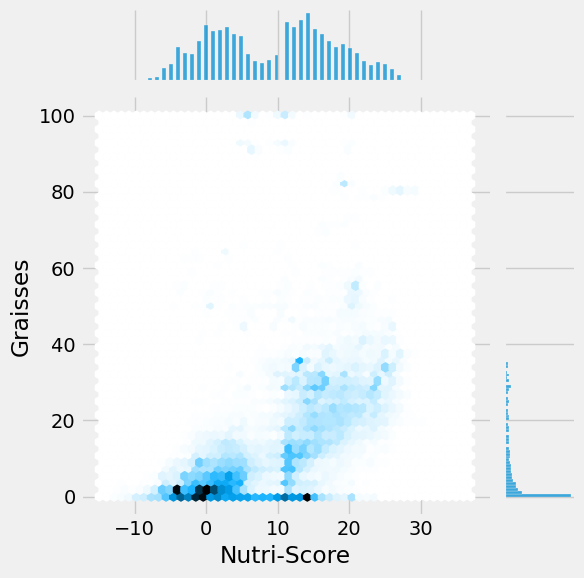

Graisses saturees  coef :  0.59 
 p-value :  0.0 
 sur  183067  enregistrements


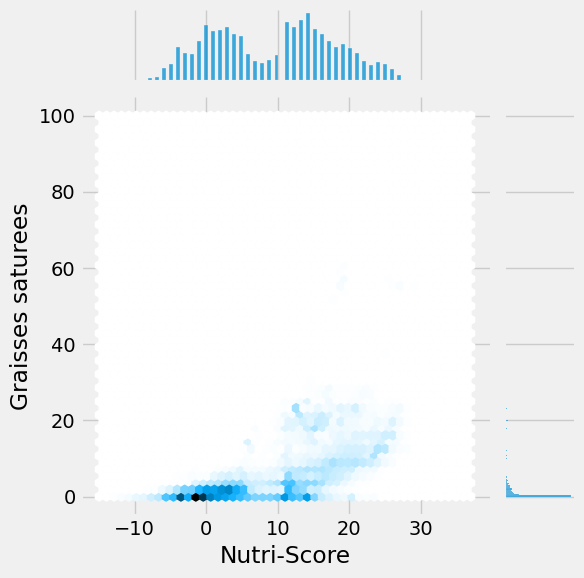

Fruits/Legumes/Noix  coef :  -0.31 
 p-value :  0.0 
 sur  5316  enregistrements


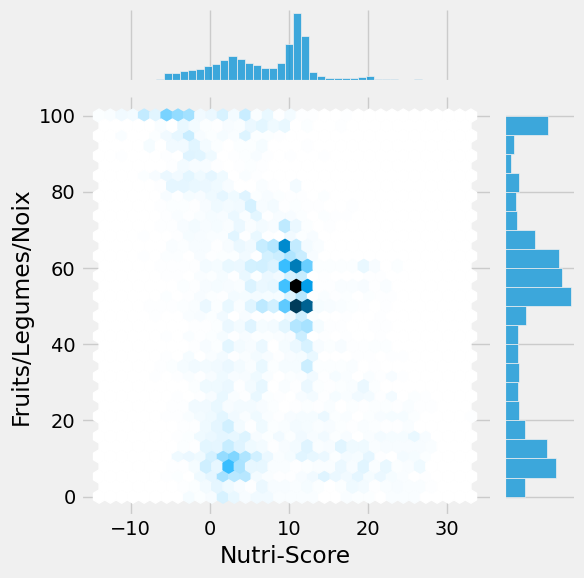

Proteines  coef :  0.13 
 p-value :  0.0 
 sur  183067  enregistrements


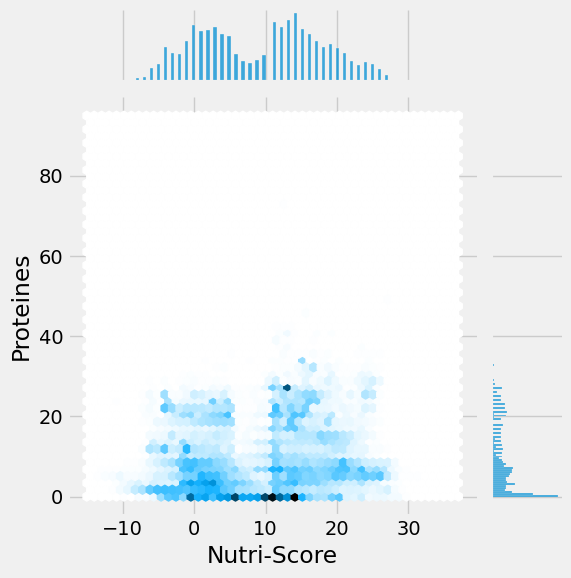

Sel  coef :  0.19 
 p-value :  0.0 
 sur  183067  enregistrements


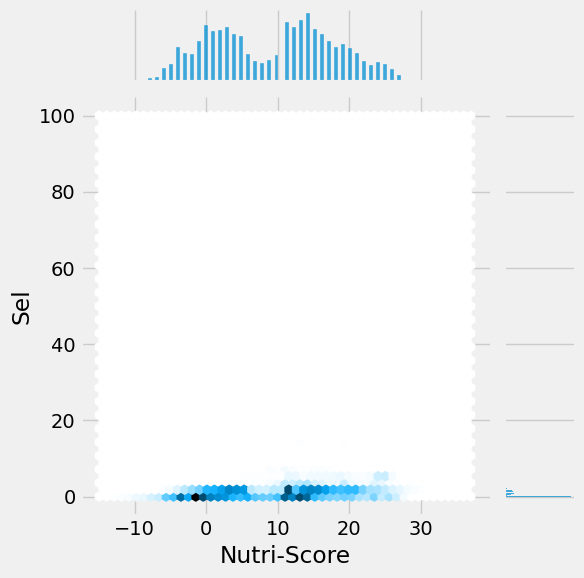

Sucres  coef :  0.32 
 p-value :  0.0 
 sur  183067  enregistrements


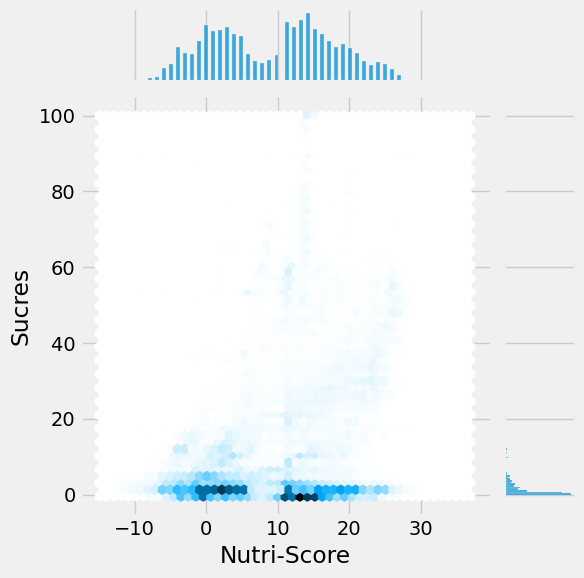

Fibres  coef :  -0.21 
 p-value :  0.0 
 sur  78783  enregistrements


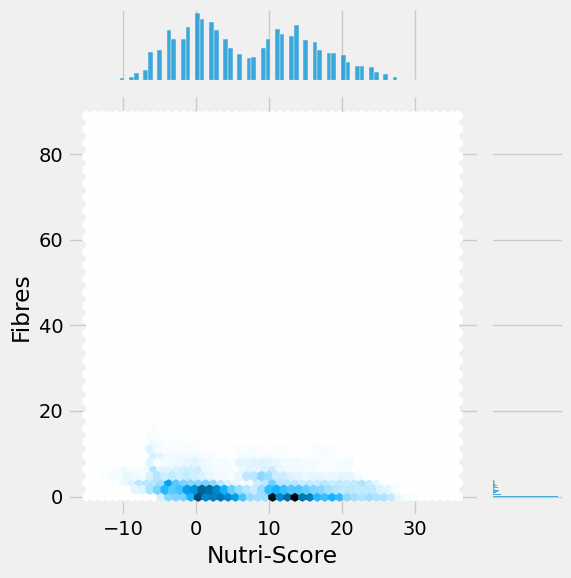

In [122]:
for i in ValeursInt :
    if i !='Nutri-Score':
        baseT2=baseT[['Nutri-Score',i]].dropna()
        taille = len(baseT2)
        Corr= stats.pearsonr(baseT2[i],baseT2['Nutri-Score'])
        print(i," coef : ", round(Corr[0],2), '\n p-value : ', round(Corr[1],1), '\n sur ',taille, ' enregistrements')
        sns.jointplot(data=baseT2, x='Nutri-Score',y=i, kind='hex')
        plt.show()
        

Etude de la relation Nutri-Score Proteines

<ipython-input-123-6cf07f69a2b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EtProt['CatProt']=np.floor_divide(EtProt['Proteines'],1.6).apply(int)
<ipython-input-123-6cf07f69a2b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EtProt['CatProt']=EtProt['CatProt'].apply(lambda x : x if x <6 else 5)


<AxesSubplot:xlabel='CatProt', ylabel='Nutri-Score'>

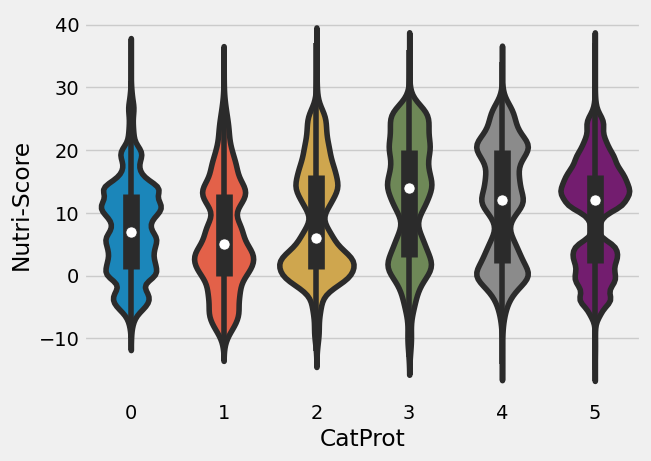

In [123]:
EtProt= baseT[['Proteines','Nutri-Score']]
EtProt['CatProt']=np.floor_divide(EtProt['Proteines'],1.6).apply(int)
EtProt['CatProt']=EtProt['CatProt'].apply(lambda x : x if x <6 else 5)
sns.violinplot(data=EtProt,y='Nutri-Score',x='CatProt')

Text(0, 0.5, 'Proteines (g)')

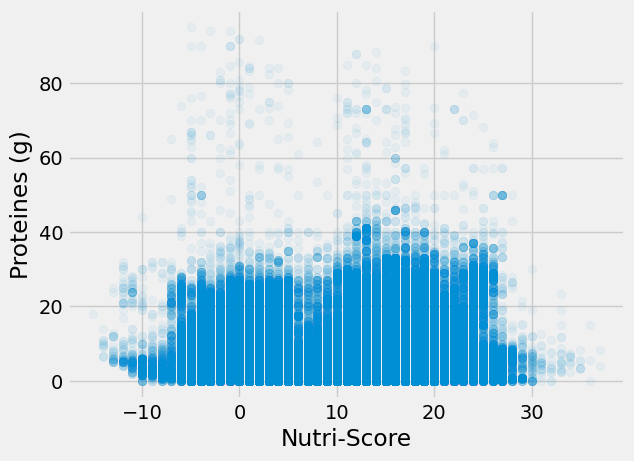

In [124]:
plt.scatter(EtProt['Nutri-Score'], EtProt['Proteines'], alpha=0.05)
plt.xlabel('Nutri-Score')
plt.ylabel('Proteines (g)')

### Coefficient de correlation Pearson entre les différentes variables numériques

<AxesSubplot:>

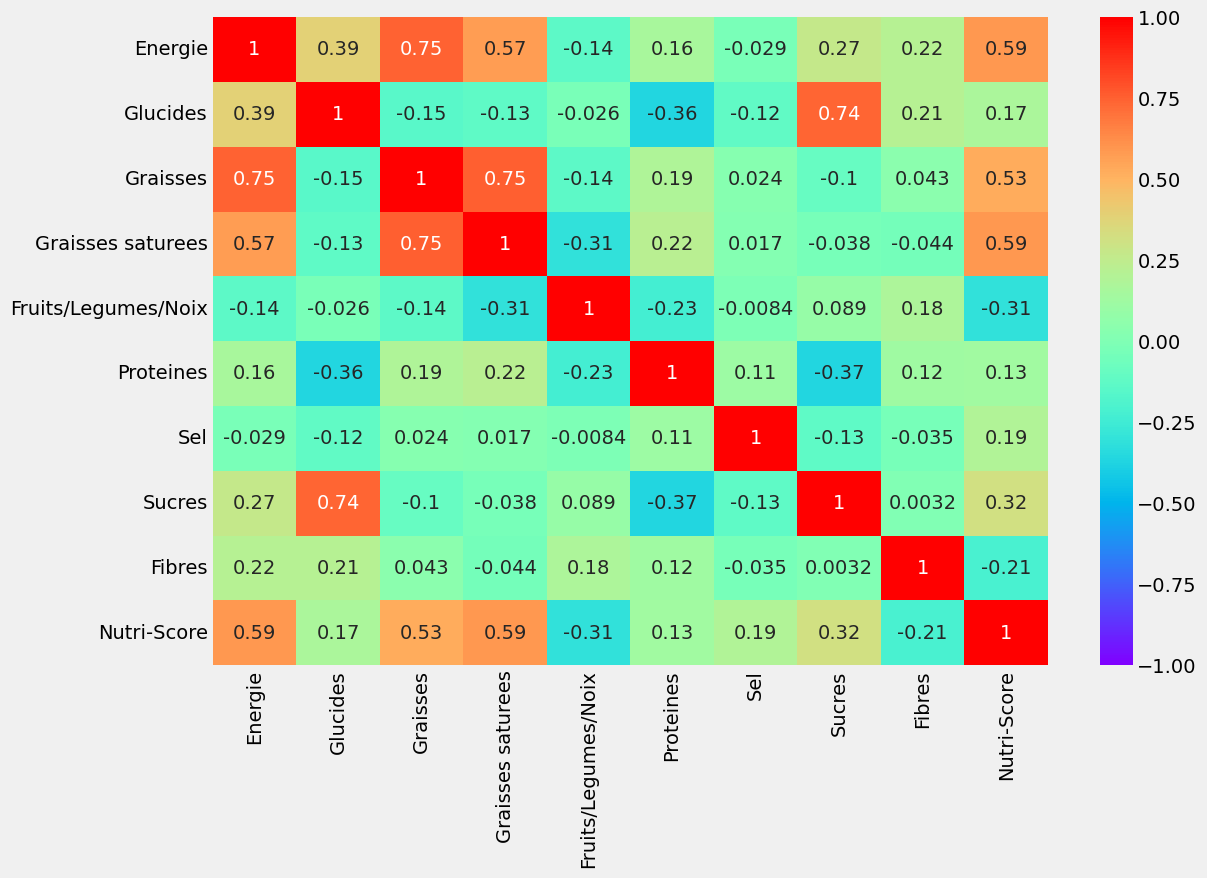

In [125]:
baseCorr =baseT[ValeursInt].corr()
plt.figure(figsize=[12,8])
sns.heatmap(baseCorr,  cmap='rainbow',center=0, vmin=-1, vmax=1, annot=True)

In [126]:
#ff=baseT.groupby(['Groupe PNNS 2','Sous-groupe PNNS 2'])[['code']].count()
#ff.to_excel('C://Users//hp//Documents//openclassrooms//projet3//pnnstab.xls')

#### Pourcentage de présence des différentes catégories de groupe PNNS

In [127]:
DisPNNS=baseT['Groupe PNNS'].value_counts(normalize=True)*100
DisPNNS

unknown                    51.207689
Fish Meat Eggs             10.689044
Sugary snacks               8.667183
Milk and dairy products     7.643404
Composite foods             4.920835
Cereals and potatoes        4.104641
Fruits and vegetables       3.419524
Beverages                   3.334065
Fat and sauces              3.092411
Salty snacks                2.921204
Name: Groupe PNNS, dtype: float64

In [128]:
baseT['Groupe PNNS'].notnull().sum()/len(baseT['Groupe PNNS'])

1.0

Text(0, 0.5, 'Pourcentage (%)')

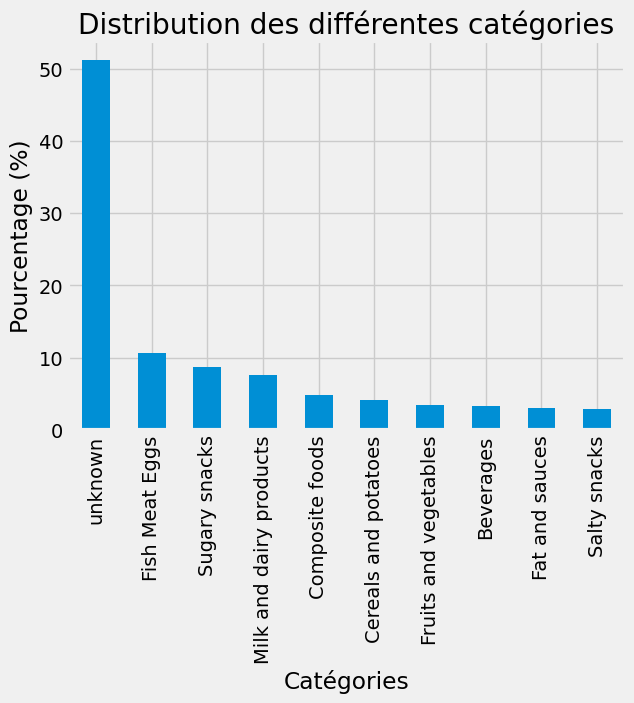

In [129]:
DisPNNS.plot(kind='bar', title='Distribution des différentes catégories')
plt.xlabel('Catégories')
plt.ylabel('Pourcentage (%)')

### relation entre le nutriscore et les pnns_group

Text(0, 0.5, 'Sous-groupes PNNS')

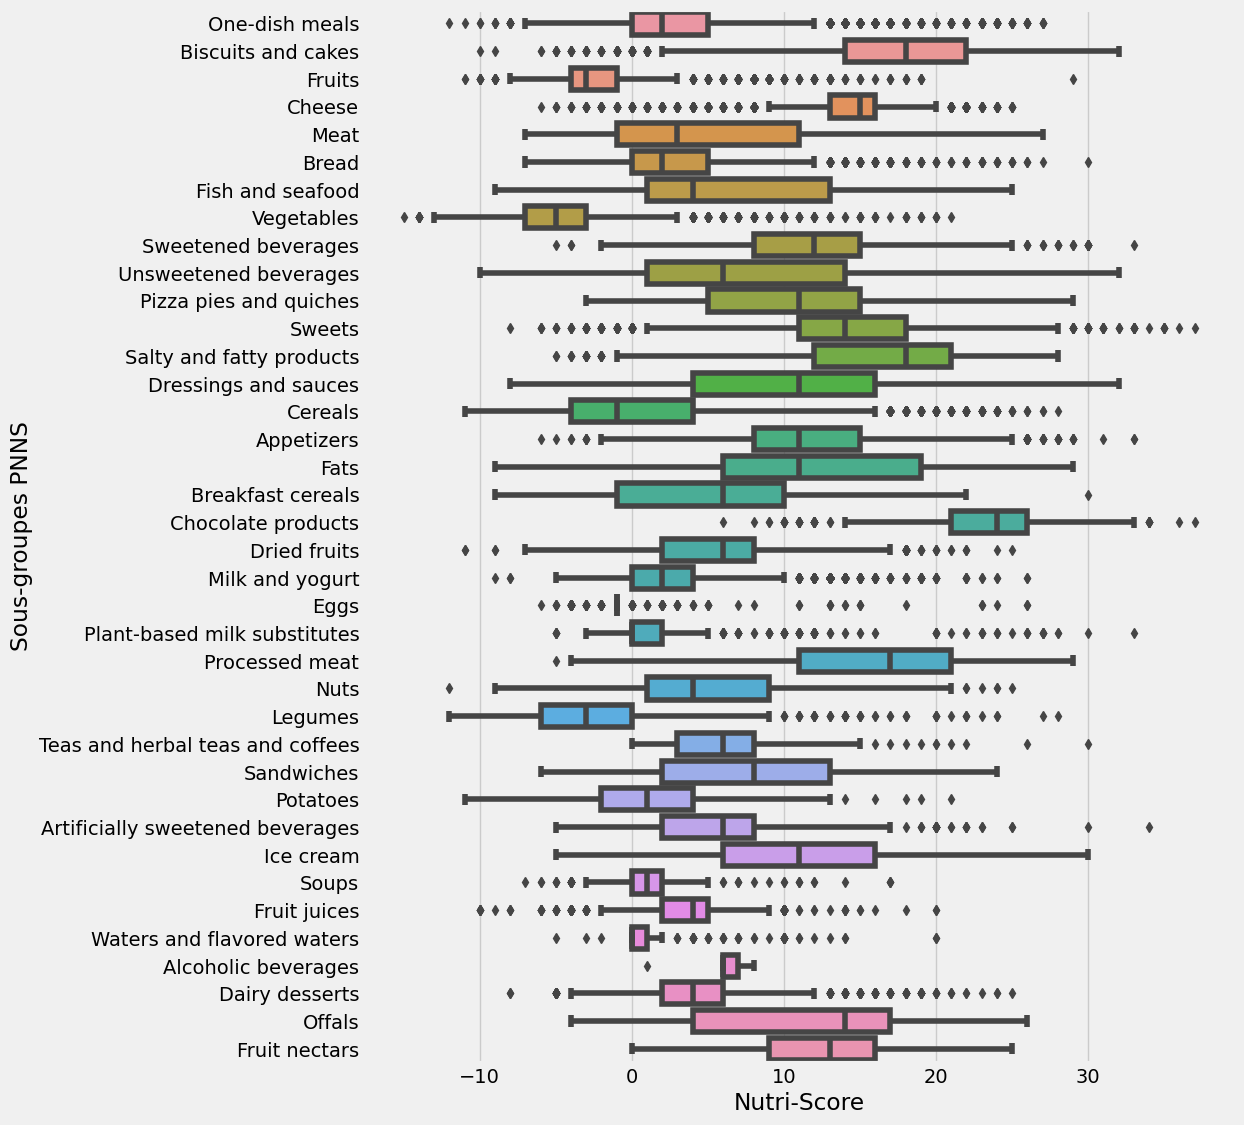

In [130]:
plt.figure(figsize=[10,13])
sns.boxplot(data=baseT, orient='h', y='Sous-groupe PNNS 2', x='Nutri-Score')
plt.ylabel('Sous-groupes PNNS')


Text(0, 0.5, 'Groupes PNNS')

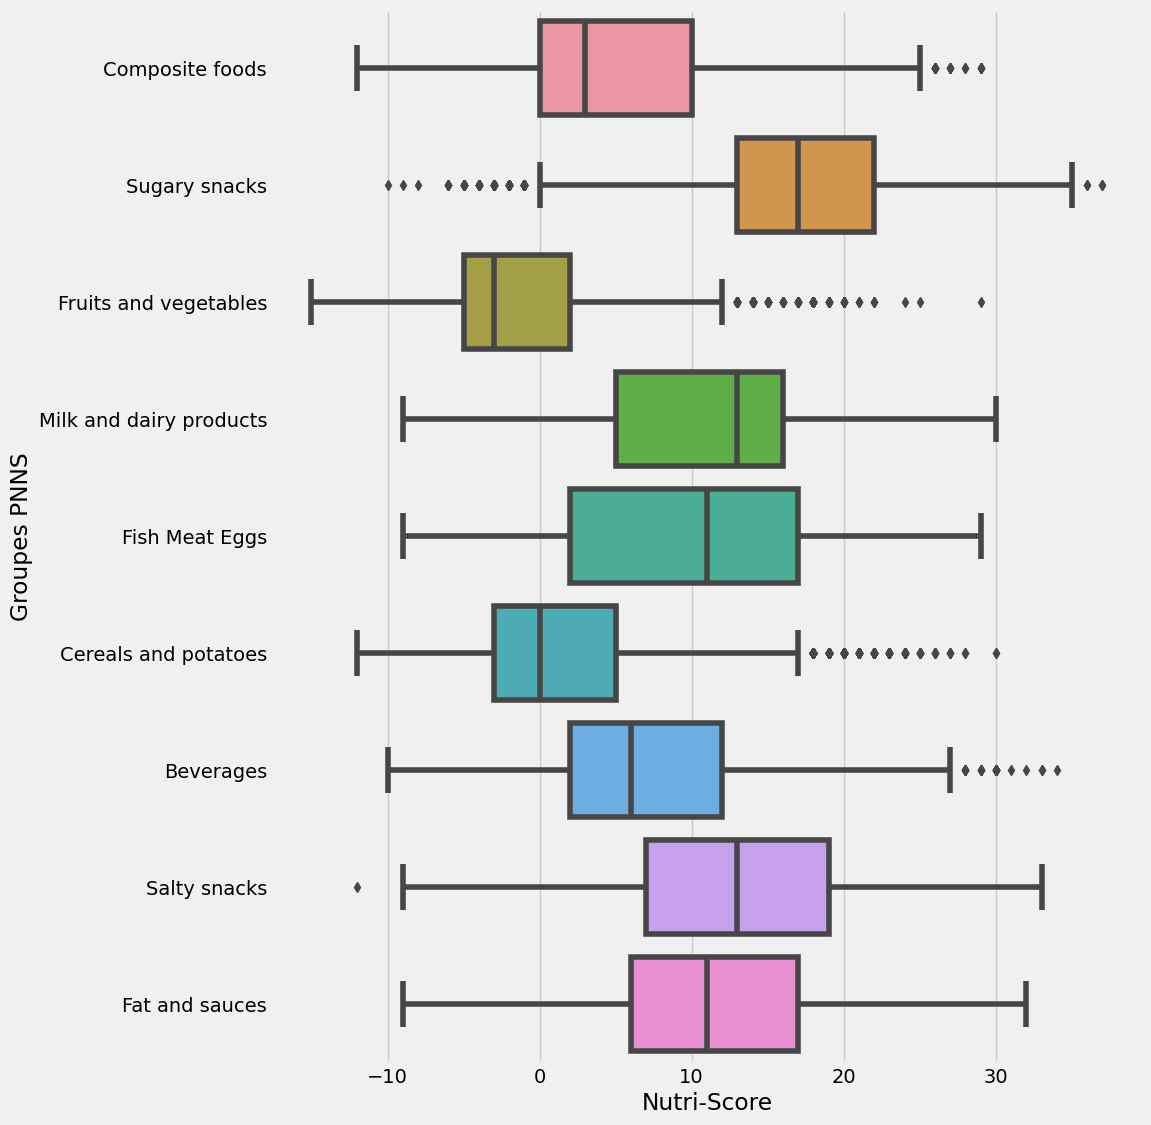

In [131]:
plt.figure(figsize=[10,13])
sns.boxplot(data=baseT, orient='h', y='Groupe PNNS 2', x='Nutri-Score')
plt.ylabel('Groupes PNNS')

In [132]:
baseT['Categorie principale'].notnull().mean()

0.5472710789804945

In [133]:
baseT['Groupe PNNS 2'].isnull().mean()

0.5138351560785763

### Aperçu des produits disponibles par catégorie

In [134]:
for i in baseT['Sous-groupe PNNS 2'].unique():
    print(i, '\n')
    print(baseT.loc[baseT['Sous-groupe PNNS 2']==i,['Nom Produit','Nutri-Score']].dropna().sort_values('Nutri-Score'))
    print('\n')   
    
    # Aperçu des produits disponibles par catégorie

nan 

Empty DataFrame
Columns: [Nom Produit, Nutri-Score]
Index: []


One-dish meals 

                                              Nom Produit  Nutri-Score
242197                                Purée de pois cassé        -12.0
197141                                 Lentilles Carottes        -11.0
241713                     Purée de Haricot Vert Surgelée        -10.0
242755                       8 Palets de légumes préfrits        -10.0
48872                        Natural plant-powerful meals         -9.0
...                                                   ...          ...
67774            Creamy Mushroom Mix For Sauces And Soups         27.0
300049  Paysan Breton - Les Crêpes au fondant et morce...         27.0
190422             Crêpes fourrées au cheddar saveur noix         27.0
217133                                    Gaufrette gouda         27.0
266345                       Magret de canard du perigord         27.0

[13272 rows x 2 columns]


Biscuits and cakes 

            

                                              Nom Produit  Nutri-Score
173896                                     Trio de quinoa        -11.0
169678                        Těstoviny z hrachu a cukety        -11.0
166719  Legumiô - lentilles corail & carottes en forme...        -11.0
52586                                           Chia Seed        -10.0
183069                       Orzo bimbo macinato per Moka        -10.0
...                                                   ...          ...
250000                                            Nouille         26.0
70235                                      Ikea Krustader         26.0
69940                       Galettes aux flocons d'avoine         27.0
20395                 Edible cookie dough, chocolate chip         27.0
6148                           Chocolate cookie pie crust         28.0

[6668 rows x 2 columns]


Appetizers 

                                              Nom Produit  Nutri-Score
253818                               

                                 Nom Produit  Nutri-Score
163661                                Litchi          1.0
72094                         Kombucha Shine          6.0
72095                         Kombucha Pêche          6.0
72096              Kombucha Citron Gingembre          6.0
72097             Kombucha Hibiscus Myrtille          6.0
168552  1664 25 cl 1664 Bio 5.5 DEGRE ALCOOL          8.0
175561                               Panaché          8.0


Dairy desserts 

                                              Nom Produit  Nutri-Score
158491                       Light & free SKYR et granola         -8.0
336212                      Crème dessert HP HC Edulcorée         -8.0
345758                                               Skyr         -5.0
228150                            Fromage blanc nature 0%         -5.0
158296                                               SKYR         -5.0
...                                                   ...          ...
193787  L'extraordin

#### Etude de la relation categorie principale / groupes pnn2

In [135]:
Etu=baseT[['Categorie principale','Groupe PNNS 2']]
Etu

,Categorie principale,Groupe PNNS 2
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,Seasoned shredded carrots,Composite foods
4,NaN,NaN
...,...,...
346359,Salted butter caramels,Sugary snacks
346360,NaN,NaN
346361,NaN,NaN
346362,Salted butter caramels,Sugary snacks


In [136]:
CatGro=Etu.apply(lambda x : Classif(x[0],x[1]), axis=1)
pieCG=CatGro.value_counts()

Text(0.5, 1.0, "Remplissage des champs 'Categorie' et 'Groupe PNNS'")

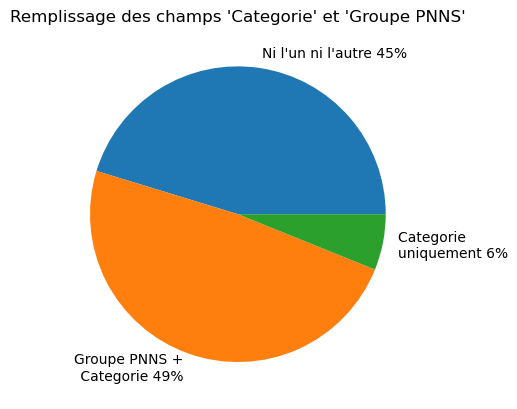

In [137]:
plt.style.use('default')
A=pieCG['Aucun']
B=pieCG['Les deux']
C=pieCG['Catégorie uniquement']
pA = int(round(A/(A+B+C)*100,0))
pB = int(round(B/(A+B+C)*100,0))
pC = int(round(C/(A+B+C)*100,0))

#pieCG.plot(kind='pie')
plt.pie([A,B,C], labels=["Ni l'un ni l'autre {}%".format(pA), 'Groupe PNNS +\n Categorie {}%'.format(pB),'Categorie \nuniquement {}%'.format(pC)])
plt.title("Remplissage des champs 'Categorie' et 'Groupe PNNS'")

## Etude des filtres

### Pays

In [138]:
SS=baseT['Pays'].value_counts(normalize=True)
SS

France                           0.721764
United States                    0.115380
Spain                            0.068985
Switzerland                      0.016271
Italy                            0.012278
                                   ...   
France,Germany,Russia,Ukraine    0.000003
Bahrain,United States            0.000003
Austria,Germany,Ireland          0.000003
Hong Kong,United States          0.000003
Spain,Belgica                    0.000003
Name: Pays, Length: 870, dtype: float64

#### Retraitement pour obtenir la fréquence des pays uniques

In [139]:
TT=baseT['Pays'].str.lower().str.split(',').explode().value_counts().sort_values()

#### Retraitement pour obtenir la fréquence des labels uniques

In [140]:
UU=baseT['Label'].str.lower().str.split(',').explode().value_counts().sort_values()
UU.nunique()

232

<ipython-input-141-e61970ec71e3>:4: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])
<ipython-input-141-e61970ec71e3>:4: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])


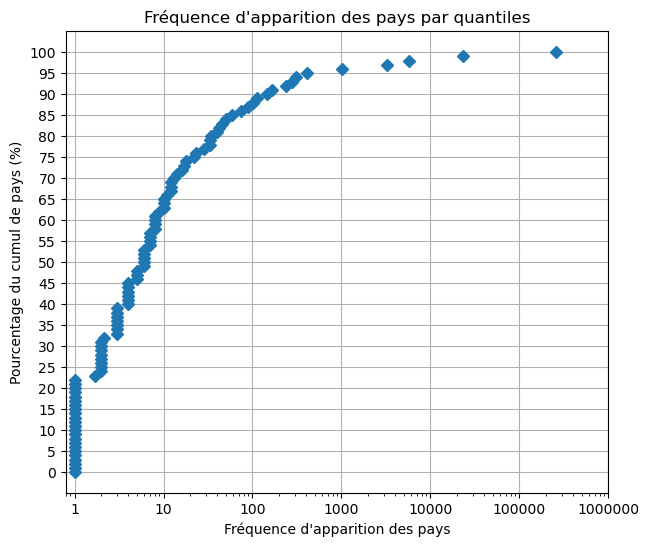

In [141]:
Percen=np.percentile(TT,np.linspace(0,100,101))
#np.percentileNomProd
plt.figure(figsize=[7,6])
plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])
plt.plot(Percen,np.linspace(0,100,101) , marker='D',linestyle='none')
plt.yticks(np.linspace(0,100,21))
plt.xlim([0.8,1000])
plt.xticks([1,10,100,1000,10000,100000,1000000],[1,10,100,1000,10000,100000,1000000])
plt.ylabel('Pourcentage du cumul de pays (%)')
plt.xlabel("Fréquence d'apparition des pays")
plt.title("Fréquence d'apparition des pays par quantiles")
plt.grid()

<ipython-input-142-027a22d069e7>:4: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])
<ipython-input-142-027a22d069e7>:4: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])


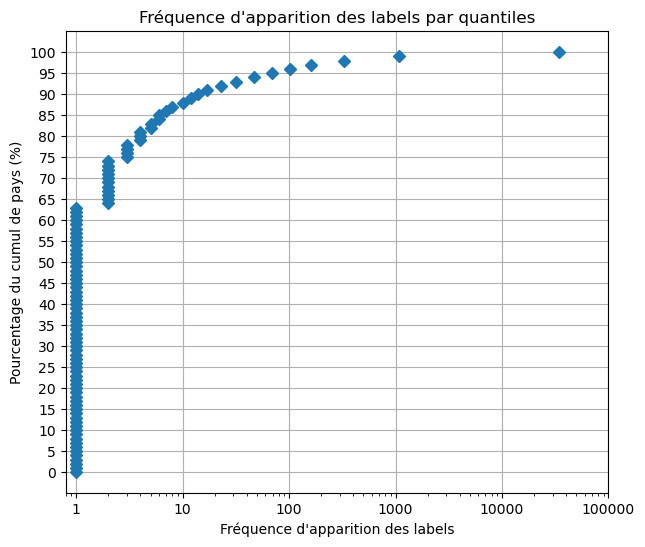

In [142]:
Percen=np.percentile(UU,np.linspace(0,100,101))
#np.percentileNomProd
plt.figure(figsize=[7,6])
plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])
plt.plot(Percen,np.linspace(0,100,101) , marker='D',linestyle='none')
plt.yticks(np.linspace(0,100,21))
plt.xlim([0.8,1000])
plt.xticks([1,10,100,1000,10000,100000],[1,10,100,1000,10000,100000])
plt.ylabel('Pourcentage du cumul de pays (%)')
plt.xlabel("Fréquence d'apparition des labels")
plt.title("Fréquence d'apparition des labels par quantiles")
plt.grid()

### Calcul de l'ANOVA des PNNS1 par rapport au nutriscore pour déterminer la pertinence des catégories

In [143]:
Pnns1=baseT[['Groupe PNNS 2','Nutri-Score']].reset_index()
Pnns1=pd.pivot_table(Pnns1,index='index',columns='Groupe PNNS 2',values='Nutri-Score')
Pnns1

Groupe PNNS 2,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,Fish Meat Eggs,Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks
index,,,,,,,,,
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
13,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,NaN,NaN
16,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
346342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
346349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
346352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0


In [144]:
f_oneway(Pnns1['Beverages'].dropna(),Pnns1['Cereals and potatoes'].dropna(),Pnns1['Composite foods'].dropna(),Pnns1['Fat and sauces'].dropna(),
Pnns1['Fish Meat Eggs'].dropna(),Pnns1['Fruits and vegetables'].dropna(),Pnns1['Milk and dairy products'].dropna(),
Pnns1['Salty snacks'].dropna(),Pnns1['Sugary snacks'].dropna())

F_onewayResult(statistic=10792.755237422043, pvalue=0.0)

### Label

#### Nombre de valeurs uniques sans retraitement

In [145]:
LblAv =baseT['Label'].value_counts(normalize=True).apply(lambda x : round(x*100,2))
len(LblAv)

17823

#### Après retraitement

In [146]:
Lbl=baseT['Label'].str.lower().str.split(',').dropna().explode()
LblAp=Lbl.value_counts(normalize=True).apply(lambda x : round(x*100,2))
len(LblAp)

4245

### Pays

#### avant

In [147]:
PaysAv =baseT['Pays'].value_counts(normalize=True).apply(lambda x : round(x*100,2))
len(PaysAv)

870

#### après

In [148]:
Pays=baseT['Pays'].str.lower().str.split(',').dropna().explode()
PaysAp=Pays.value_counts(normalize=True).apply(lambda x : round(x*100,2))
len(PaysAp)

217

### Enregistrement de la base modifiée

In [149]:
baseT.to_csv('BaseRetraitee.csv')